# Auto Encoders

## Setup and Context

### Introduction

An autoencoder is a type of neural network used to learn efficient codings of unlabeled data. It is designed for unsupervised machine learning. An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation. The autoencoder learns an efficient representation (encoding) for a set of data, typically for dimensionality reduction.

In this example, we are making a Convolutional Variational Autoencoder.

### Import Statements

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
LATENT_DIM = 32
BATCH_SIZE = 64

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

## The Data

### Getting the Training and Test Sets

We would be using the **MNIST dataset** which is a collection of handwritten digits. We also convert our training and test set to pytorch tensors. **PyTorch tensors** are multi-dimensional arrays similar to NumPy arrays, but with additional features and optimizations for deep learning tasks.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Let's visualize some data from the training set.

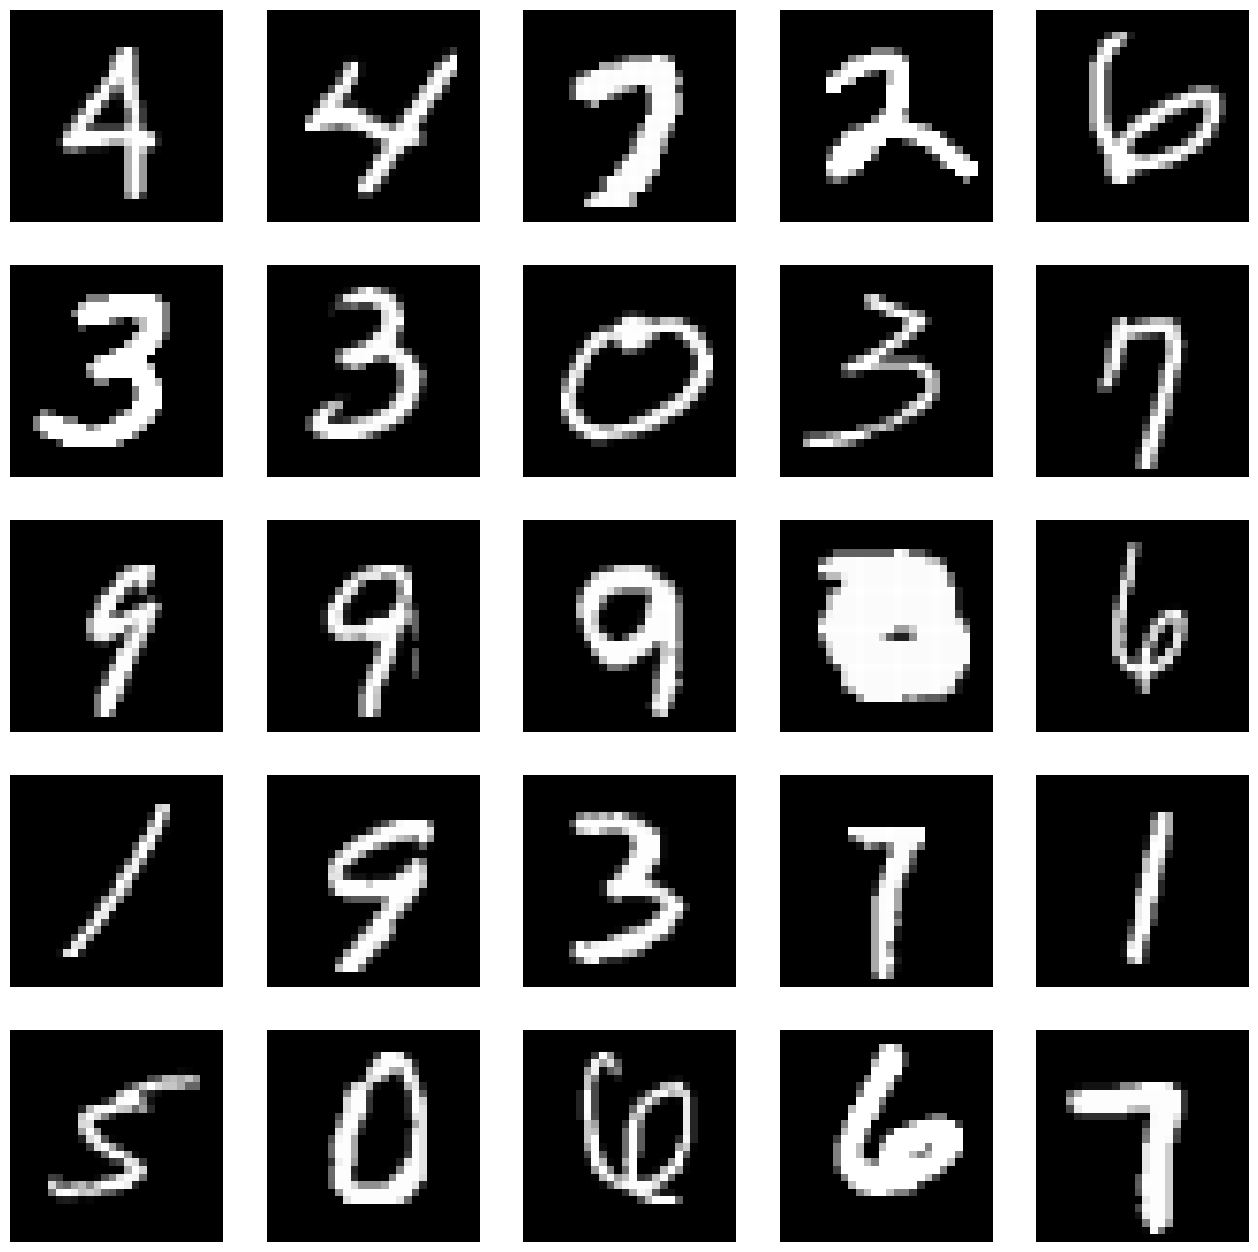

In [6]:
dataiter = iter(train_loader)
images, _ = next(dataiter)

plt.figure(figsize=(16, 16))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')

plt.show()

## The Neural Network

### The Loss Function

For our loss, we are using a combination of the Binary Cross-Entropy and something called [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [7]:
def vae_loss(recon_x, x, mu, logvar):
    # Compute binary cross-entropy (BCE) loss 
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # Compute the Kullback-Leibler (KL) divergence loss term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss is the sum of the BCE loss and the KLD loss
    return BCE + KLD

### Creating the Neural Network Architecture

We want to create a Variational Autoencoder class. To make the class using pytorch, we need to define multiple things: the layers, the number of layers, how many nodes in the layers, the activation function, the criterion, the optimizer function.

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        # Latent space representation
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim) # Fully connected layer to output mean of the latent space
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim) # Fully connected layer to output log variance of the latent space

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid() # We use sigmoid because we want the range of values of our outputs to be the same as our inputs [0, 1].
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Compute the standard deviation from the log variance
        eps = torch.randn_like(std)  # Generate samples from standard normal distribution
        return mu + eps * std  # Reparameterization trick to sample from the learned distribution

    def forward(self, x):
        # Encode
        x = self.encoder(x)  # Pass input through the encoder to obtain feature representation
        
        # Obtain latent space parameters
        mu = self.fc_mu(x)  # Compute the mean of the latent space
        logvar = self.fc_logvar(x)  # Compute the log variance of the latent space
        
        # Reparameterization
        z = self.reparameterize(mu, logvar)  # Sample from the learned distribution using the reparameterization trick
        
        # Decode
        x_recon = self.decoder(z)  # Reconstruct the input from the sampled latent space representation
        return x_recon, mu, logvar  # Return the reconstructed input, mean, and log variance

Next, we create an object of the variational autoencoder class, `vae`, and initializes the Adam optimizer, `optimizer`.

In [9]:
vae = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

### Training the Autoencoder

We train our model using the provided training data. It iterates over each epoch and each item in the training set, computes the  loss, and updates the model parameters accordingly.

In [10]:
num_epochs = 100

vae.train() # Set the VAE model to training mode
for epoch in range(num_epochs):
    total_loss = 0.0 # Initialize the training loss for this epoch
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad() # Zero the gradients for the optimizer

        data = data.to(device)
        # Forward pass: compute reconstruction and latent space parameters
        recon_batch, mu, logvar = vae(data)
        
        # Compute the VAE loss
        loss = vae_loss(recon_batch, data, mu, logvar)

        # Backward pass: compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        # Accumulate the training loss for this batch
        total_loss += loss.item()
    # Print the average training loss for this epoch
    print(f'Epoch: {epoch + 1}/{num_epochs}\tLoss: {total_loss / len(train_loader.dataset)}')

Epoch: 1/100	Loss: 171.05395551757812
Epoch: 2/100	Loss: 126.23194769287109
Epoch: 3/100	Loss: 120.25748076985677
Epoch: 4/100	Loss: 117.18022169189453
Epoch: 5/100	Loss: 115.19905192871094
Epoch: 6/100	Loss: 113.76947529703776
Epoch: 7/100	Loss: 112.69825134277343
Epoch: 8/100	Loss: 111.84894171549479
Epoch: 9/100	Loss: 111.1990013671875
Epoch: 10/100	Loss: 110.65769632975261
Epoch: 11/100	Loss: 110.06836256103516
Epoch: 12/100	Loss: 109.64876129964193
Epoch: 13/100	Loss: 109.21124741210937
Epoch: 14/100	Loss: 108.8836706217448
Epoch: 15/100	Loss: 108.53842900797527
Epoch: 16/100	Loss: 108.23275988769531
Epoch: 17/100	Loss: 107.94821572265624
Epoch: 18/100	Loss: 107.71411871744792
Epoch: 19/100	Loss: 107.40951750895182
Epoch: 20/100	Loss: 107.2525524617513
Epoch: 21/100	Loss: 107.04883216552734
Epoch: 22/100	Loss: 106.80754702148438
Epoch: 23/100	Loss: 106.68493479003907
Epoch: 24/100	Loss: 106.5003629720052
Epoch: 25/100	Loss: 106.28683708089193
Epoch: 26/100	Loss: 106.18065036621094

### Testing the Autoencoder

Finally, we will test the our autoencoder using the test set.

In [11]:
# Set the VAE model to evaluation mode
vae.eval()

# Initialize test loss
test_loss = 0

# Disable gradient computation for efficiency
with torch.no_grad():
    # Iterate over the test dataset
    for data, _ in test_loader:
        # Perform forward pass to obtain reconstructed images and latent space parameters
        data = data.to(device)
        recon_batch, mu, logvar = vae(data)
        
        # Compute VAE loss for this batch and add it to the total test loss
        test_loss += vae_loss(recon_batch, data, mu, logvar).item()

# Calculate average test loss
test_loss /= len(test_loader.dataset)

# Print the average test loss
print(f'Test Loss: {test_loss}')

Test Loss: 101.3847768798828


### Sampling from our Autoencoder

Sampling, in the context of a Variational Autoencoder, refers to generating new data points by randomly sampling points from the learned distribution of latent variables. So let us visualize some samples.

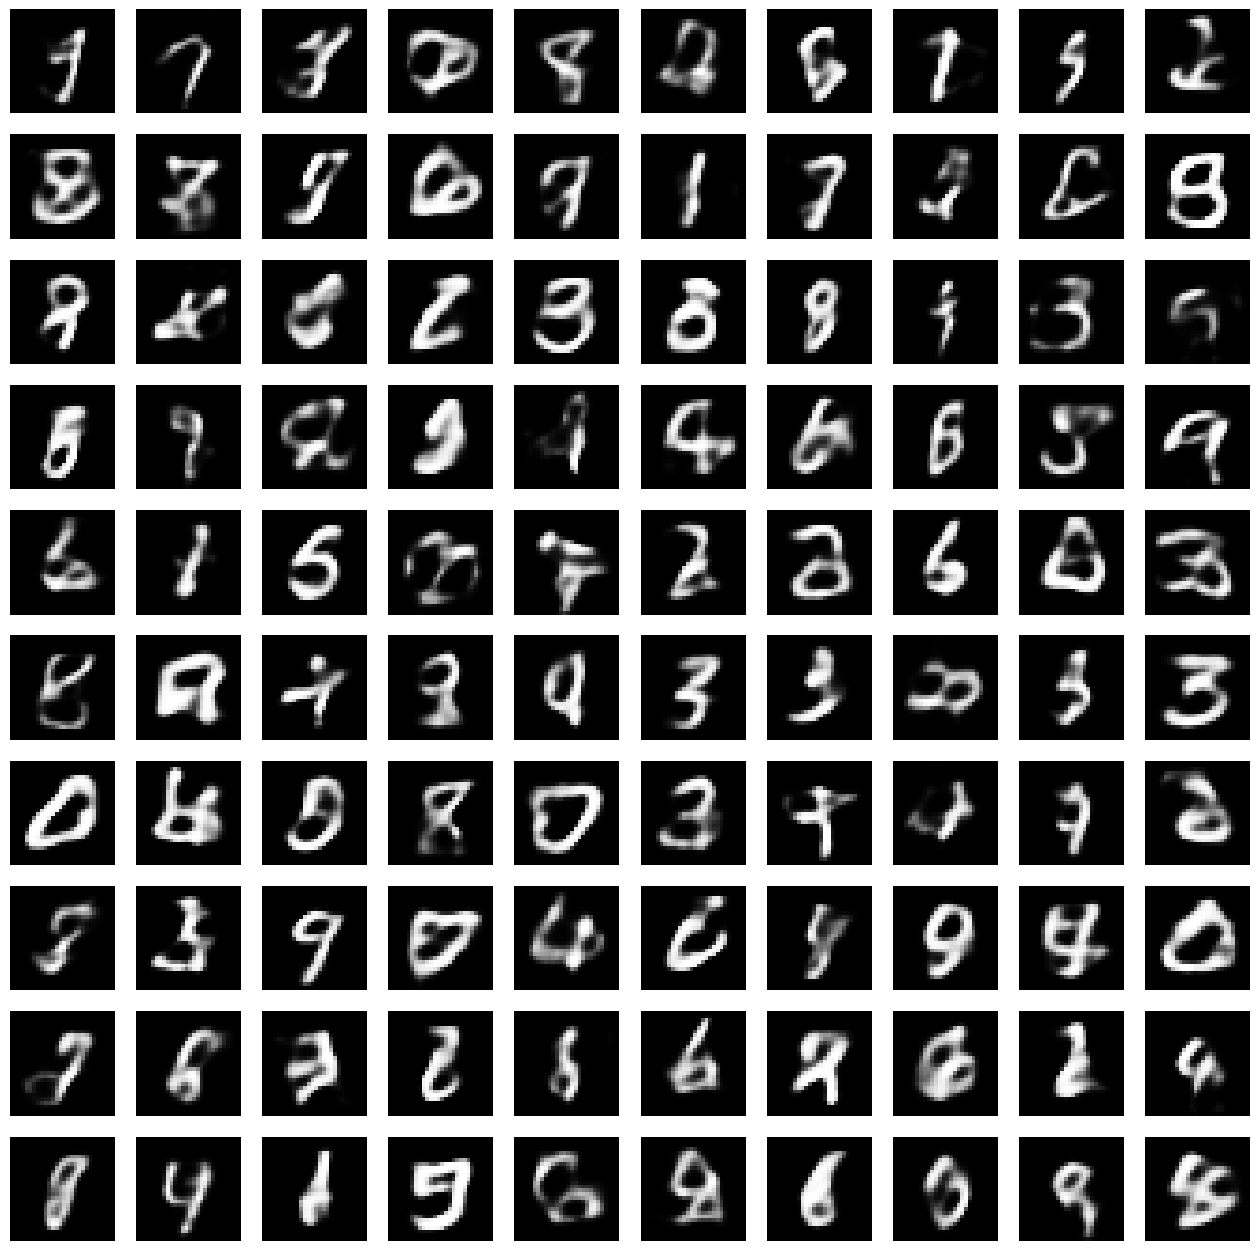

In [12]:
num_samples = 100

# Set the model to evaluation mode
vae.eval()

# Sample from the model
with torch.no_grad():
    # Sample latent vectors from a standard normal distribution
    z = torch.randn(num_samples, LATENT_DIM).to(device)
    
    # Decode the samples
    reconstructed_images = vae.decoder(z)

# Visualize the reconstructed images
plt.figure(figsize=(16, 16))
for i in range(num_samples):
    plt.subplot(10, 10, i+1)
    plt.imshow(reconstructed_images[i].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()